In [5]:
import warnings
from typing import (List, Tuple, Dict, Callable, Union)

import pandas as pd
import numpy as np
import empyrical as ep

from scr import get_dataset

# 一、探索生命周期划分方法

根据企业生命周期理论，企业如同一个生命有机体，一般会经历导入、成长、成熟和 衰退等阶段，处于不同生命周期阶段的企业具有不同的特征。从投资者的角度来看， 针对处于不同阶段的企业，对其投资价值的考察标准应当也有所不同。本文就这一问 题，尝试分析处在各个不同生命周期的企业群体中的因子的有效性，从而更好地运用 因子投资的方法来筛选出具有超额收益的个股。首先，我们需要对上市公司进行生命周期的划分,常见的生命周期划分方法如下。

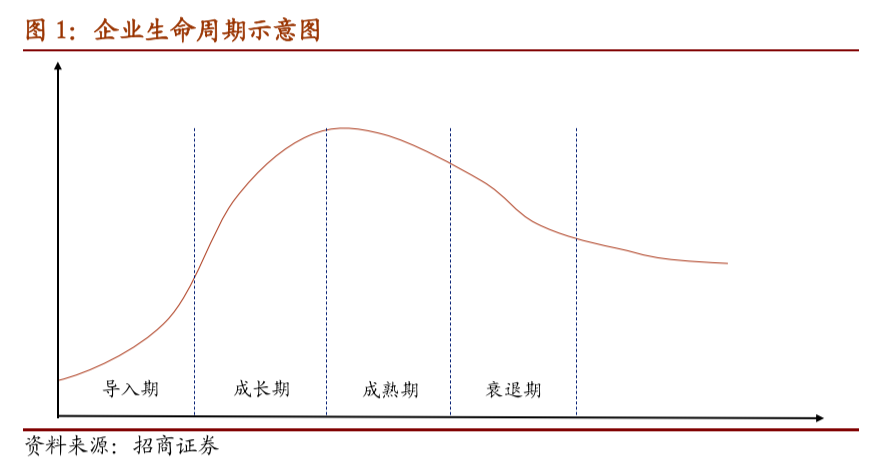

## 1.1 行业周期定位法
行业周期定位法，顾名思义，就是根据行业所处的生命周期来判断业内企业的生命周期。 例如，如果判断银行行业处于成熟阶段，那么所有银行企业都被划分入成熟这一阶段。 这样的划分方法相对简单直接，但同时存在两个缺点。一方面，主观判断容易对划分结 果形成较大影响，无法进行有效的历史回溯，进而无从通过实证研究验证相关逻辑。另 一方面，这种划分方式更偏静态，忽视了企业本身所处生命周期的动态变化。此外，同 一行业下的企业可能所处的经营周期是不同的，即使是在成熟的行业中，也可能存在初创企业正处在导入期。

## 1.2 变量分析法

变量分析法可分为单变量分析法和综合指标分析法。例如，DeAngelo（2006）采用留 存收益/净资产（或者总资产）作为划分企业生命周期的依据，根据研究股利支付行为来 判断企业所在阶段。Anthony（1992）、Chiung-Ju Liang（2011）、孙建强等（2003） 宋常和刘司慧（2011）等人都通过诸如营销费用率、销售增长率、高管持股比率、公司 年龄和运营能力等指标，通过设定打分标准给每个指标进行打分，而后利用公司得分所在区间来判断生命周期。


这一类生命周期定位法可以综合考虑多个指标，但存在的缺陷也显而易见，在得分的 设计标准上过于主观，我们需要人为构建单个财务指标的得分标准，以及总得分映射 到生命周期不同阶段的标准。并且，哪些指标需要被考虑，指标间是否等价，也同样
需要制定者做出主观判断。

## 1.3 象限划分法

本文我们将提出一种新的企业生命周期划分法，即以ROE为横轴、营收增长1为纵轴构 建二维坐标系，并根据企业所处象限来划分其经验生命周期。这样划分的逻辑较为直观 和清楚，符合投资者惯用的投资理念，并且可以刻画出生命周期变化是一个连续的过程。 具体来说，当企业从导入期介入某一产业，企业初始的营业收入基数较低，因此营收增 长率处于较高的阶段；但其资本回报率较低，ROE 处在较低的水平，此时企业处于导 入期，即坐标系的左上方。随后，经过一定时期的发展，企业持续高增长，带动资本回报率上升，ROE 水平有所提升。此时企业处于成长期，即坐标系的右上方。而当企业渗透率和竞争格局达到较为稳定时，必然面临增长率放缓的情况，此时企业就由成长期 转入成熟期，位于坐标系的右下方。而当企业由于自身或产业原因，盈利能力出现下滑
时，则进入了衰退期，即坐标系的左下方。

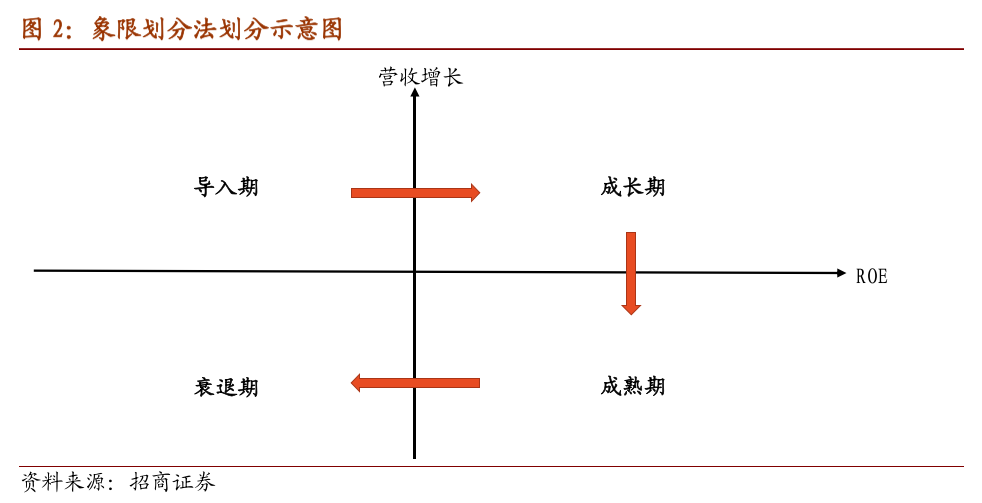

这里说一下细节：

1. **ROE为ROE_TTM,营收增长为三年复合营收增长率(回归法)**;
2. **未修正的象限使用的两个指标的中位数确定；**
3. **修正的象限为营收对ROE做的回归拟合**

# 数据获取

In [3]:
# 数据获取
get_dataset.get_data('all')

数据获取(起始日:2013-01-01,结束日:2022-02-28
开始划分高低端象限...


高低端象限数据获取完毕!
开始划分四象限...


四象限数据获取完毕!
开始获取因子数据...


因子数据获取完毕!
开始获取收盘价数据...


收盘价数据获取完毕!


# 读取数据

In [6]:
dichotomy, quandrant, factors_frame, pricing = get_dataset.load_data()

dichotomy.csv文件读取完毕!
quandrant_df.csv文件读取完毕!
factors_frame.csv文件读取完毕!
pricing.csv文件读取完毕!


# 二、评估因子在不同阶段下的有效性

在定位企业所处经营周期时，直接从二维度量分析显得略微复杂，不方便通过测试寻找 到有效的Alpha 因子。因此，我们尝试拆解二维坐标系为两个一维视角，希望可以在一维分析得到有效因子后，再将因子结合得到不同生命周期下有效的因子。

## 2.1 低端ROE端

**低ROE端股票基本面支撑较弱，炒作风气偏重。**当股票ROE较小时，其整体收益波动也更大，通常也更易受到技术投资者、短线投机 者的关注。因此，我们认为这一类股票更适用**量价指标**，本次我们选用了四个典型的量价因子进行测试。

|指标名称|计算方式|因子符号|
|--|--|--|
|VolAvg_20D_240D|过去 20 天日均成交量 / 过去 240 天日均成交量|负|
|VolCV_20D|过去 20 天日成交量的标准差 / 过去 20 天日均成交量|负|
|RealizedSkewness_240D|过去 240 天日收益率数据计算的偏度|负|
|ILLIQ_20D|过去 20 天 AVERAGE(日涨跌幅绝对值 / 日成交金额)|正|

接下来，我们在每个月末将股票根据ROE分为三个组4，在每个组内分别对上述四个量 价指标和四个指标合成的复合指标进行IC测试

In [9]:
from scr.analyze_func import get_factor_res
from scr.plotting import plotting_dichotomy_res
from scr.my_scr import (quadrant_dic, dichotomy_dic)

In [10]:
# 获取roe高端/低端,营收高端/低端的数据
res = get_factor_res(dichotomy,
                     factors_frame,
                     pricing,
                     dichotomy_dic,
                     group_num=3)

可以看到低ROE端因子单调性都较好

- ILLIQ_20D:第三组（高分组）收益较好，但IC较低为1.79%(分组中最低,较为异常)；
- RealizedSkewness_240D:第一组(低分组)收益较好,IC为3.05%(分组中最高)；
- VolAvg_20D_240D:第一组(低分组)收益较好,IC为-0.34%(分组中最低,较为异常)；
- VolCV_20D:第一组(低分组)收益较好,IC为-2.63%(分组中最高)；



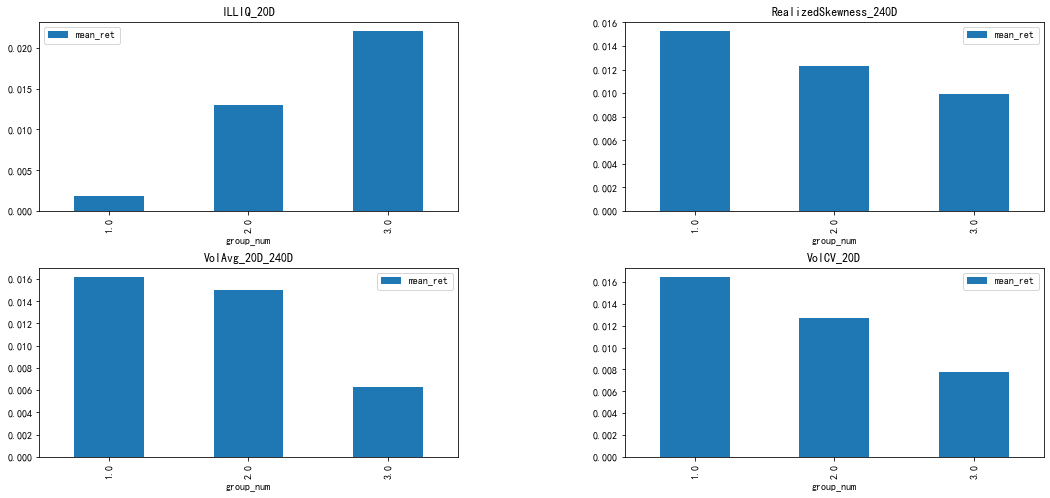

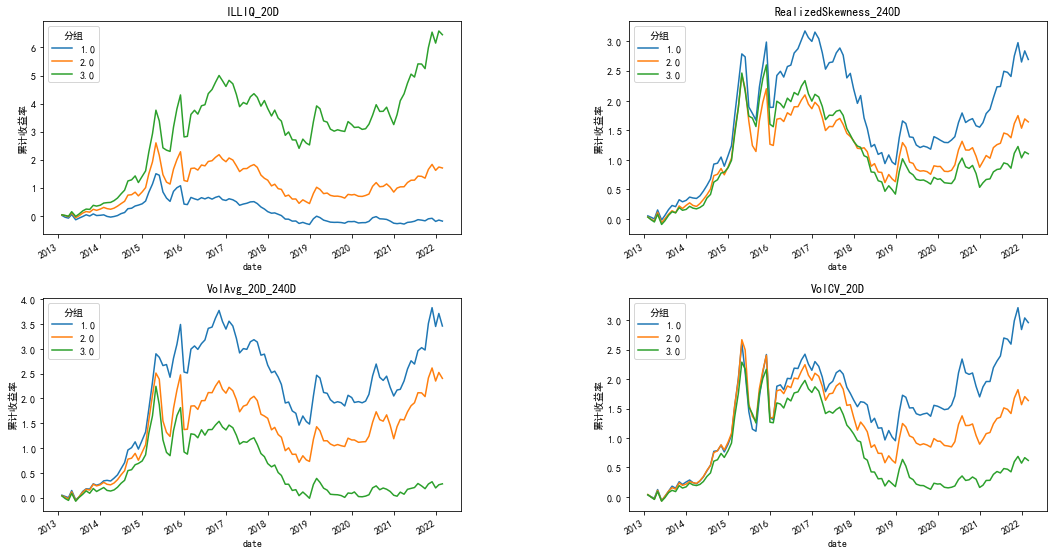

In [11]:
plotting_dichotomy_res(res['低ROE端'])

## 2.2 高ROE端

ROE端股票有较好的基本面支撑，受到价值投资者和专业的机构投资者更多的青睐。在ROE较大的股票分组中，分析师覆盖率也就越高，这也就印证了专业投资者更关心高ROE股票这一观点。因此，我们尝试利用三个**分析师预期边际变化因子**，进行与之前一样的测试以验证我们的逻辑。

|指标名|计算方法|因子符号|
|--|--|--|
|EPS_FY1_R3M|一致预期 EPS相对于 3 个月前的变化|正|
|Sales_FY1_R3M|一致预期营业收入相对于 3 个月前的变化|正|
|Operatingprofit_FY1_R20D|一致预期营业利润相对于3个月前的变化|正|

**由于聚宽数据问题这里仅构建了Operatingprofit_FY1_R20D因子**

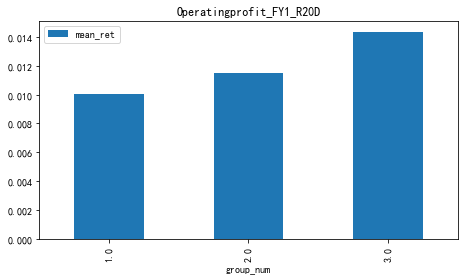

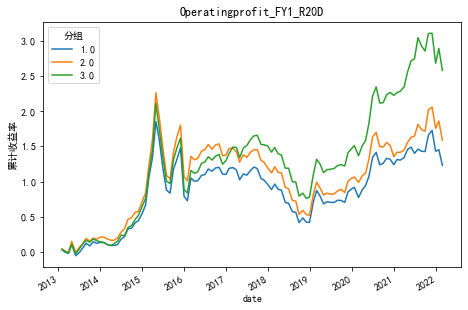

In [6]:
plotting_dichotomy_res(res['高ROE端'])

## 2.3 低增长端

当企业发展进入低增长的稳定期，细分市场的格局相对稳定。此时标的股票买的是否“便宜”，股票价格是否值得购买则变得更为重要。我们认为这一阶段的股票更适用于使用考虑"性价比"的**价值稳定指标**。

|指标名|计算方法|因子符号|
|--|--|--|
|BP_LR|股东权益合计(不含少数股东权益)_最新财报 / 总市值|正|
|EP_Fwd12M|每股收益_未来 12 个月预测值 / 收盘价|正|
|Sales2EV|营业收入_TTM / (总市值 + 非流动负债合计_最新财报 货币资金_最新财报)|正|

低增长端因子单调性较好
- Gross_profit_margin_chg:第三组收益较高(高分组),IC为-1.27%(分组中最低,较为异常);
- Netprofit_chg:第三组收益较高(高分组),IC为-1.64%(分组绝对值最高);

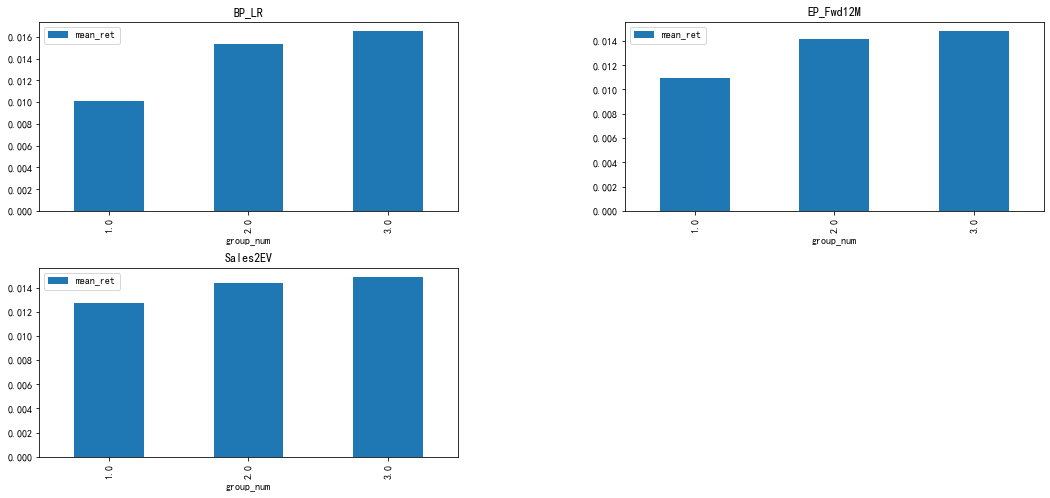

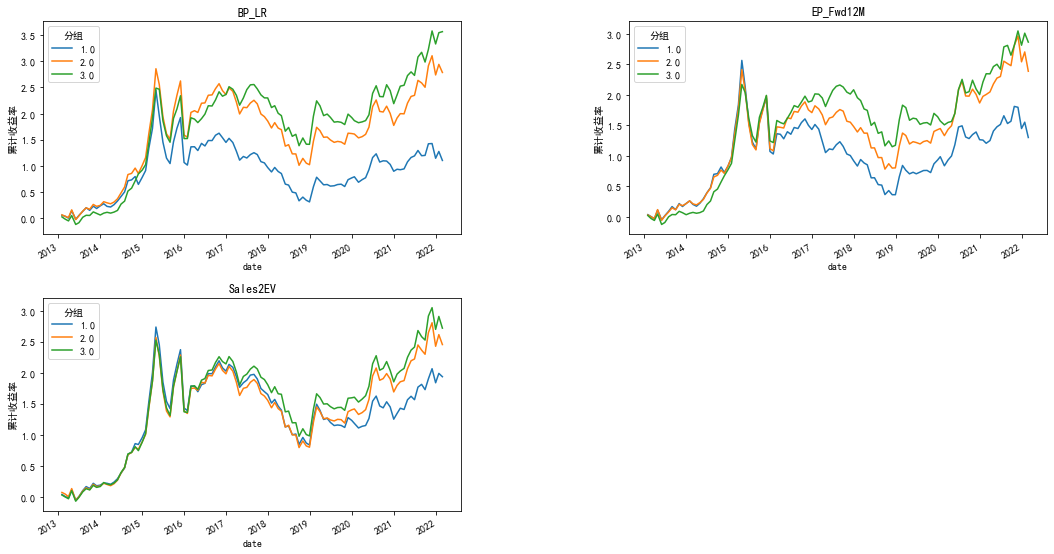

In [7]:
plotting_dichotomy_res(res['低增长端'])

## 2.4 高增长端

高增长端股票本身具有较高的成长性，很直观地，其成长能力的可持续性备受关注。因此，我们认为这一阶段股票的成长质量显得尤为重要，接下来我们选用了如下三个成长质量因子进行测试。
|指标名|计算方法|因子符号|
|--|--|--|
|Gross profit margin_chg|销售毛利率（毛利/营业收入）同比变化|正|
|Netprofit_chg|近半年利润增速变化|正|
|Expected_Profit_Growth|预期未来两年复合利润增速|正|

**由于聚宽数据问题这里仅构建了Gross_profit_margin_chg、Netprofit_chg因子**

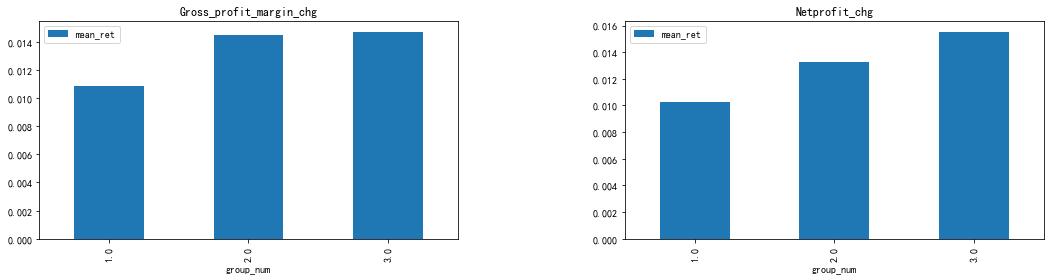

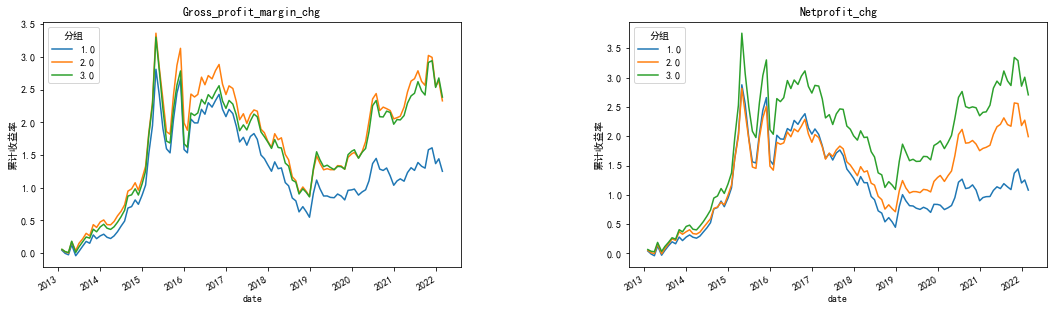

In [8]:
plotting_dichotomy_res(res['高增长端'])

## 2.5 复合因子测试

在一维层面进行拆分分析之后，我们将所得到的因子进行组合，具体组合如下图所示。 通过一维分析，我们可以得到每个生命周期中两类有效性相对较好的强势因子。同样地， 我们可以把斜对角线的另外两个因子视为在这一生命周期阶段表现弱势的因子。在下一 步的测试中，我们将两个强势因子复合得到阶段强势因子，将两个弱势因子复合得到阶段弱势因子。其中，测试中的基准为处于相同生命周期的所有股票的等权组合。

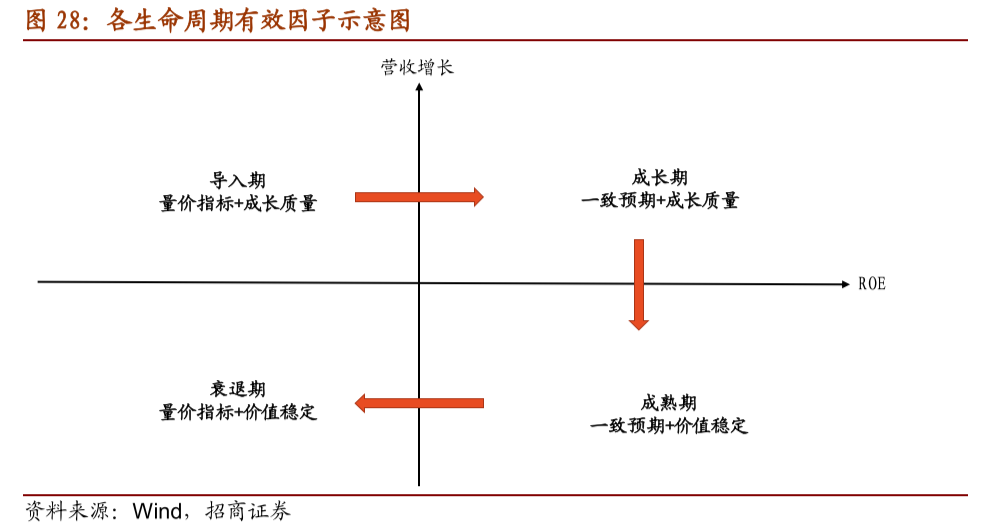

In [12]:
from scr.analyze_func import (perf_stats, get_com_returns, get_com_frame)
import factor_tools.composition_factor as comp_factor
from scr.my_scr import (FACTOR_DIC, QUADRANT2FACTOR)
from scr.utils import get_max_factor_name

In [13]:
def direction()->Dict:
    """获取象限复合因子方向

    Returns:
        Dict
    """
    # 因子方向描述
    ## 根据前序数据整理
    factor_rank_dict = {
        'ILLIQ_20D': 'ascending',
        'RealizedSkewness_240D': 'descending',
        'VolAvg_20D_240D': 'descending',
        'VolCV_20D': 'descending',
        'Operatingprofit_FY1_R20D': 'ascending',
        'BP_LR': 'ascending',
        'EP_Fwd12M': 'ascending',
        'Sales2EV': 'ascending',
        'Gross_profit_margin_chg': 'ascending',
        'Netprofit_chg': 'ascending'
    }
    
    direction = {}
    
    for k,v in QUADRANT2FACTOR.items():
        factor_des = {}
        for factor_type in v:
            
            for factor_name in FACTOR_DIC[factor_type]:
                
                factor_des[factor_name] = factor_rank_dict[factor_name]
                
        direction[k] = factor_des
        
    return direction

In [14]:
# 使用PCA合成因子
direction_dic = direction()

res2 = get_factor_res(quandrant,
                      factors_frame,
                      pricing,
                      quadrant_dic,
                      group_num=3,
                      direction=direction_dic,
                      comp_params={'method':'pca',
                                   'window':5,
                                   'is_rank':False})

### 导入期

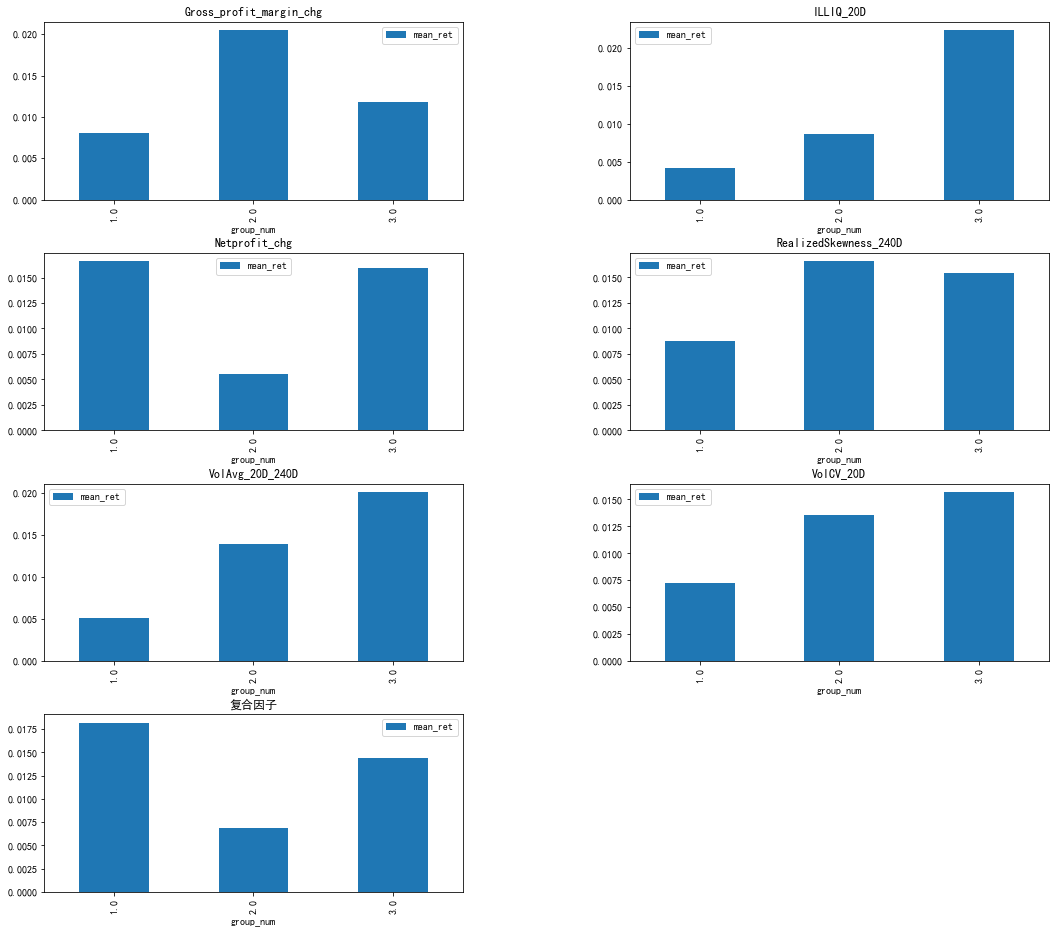

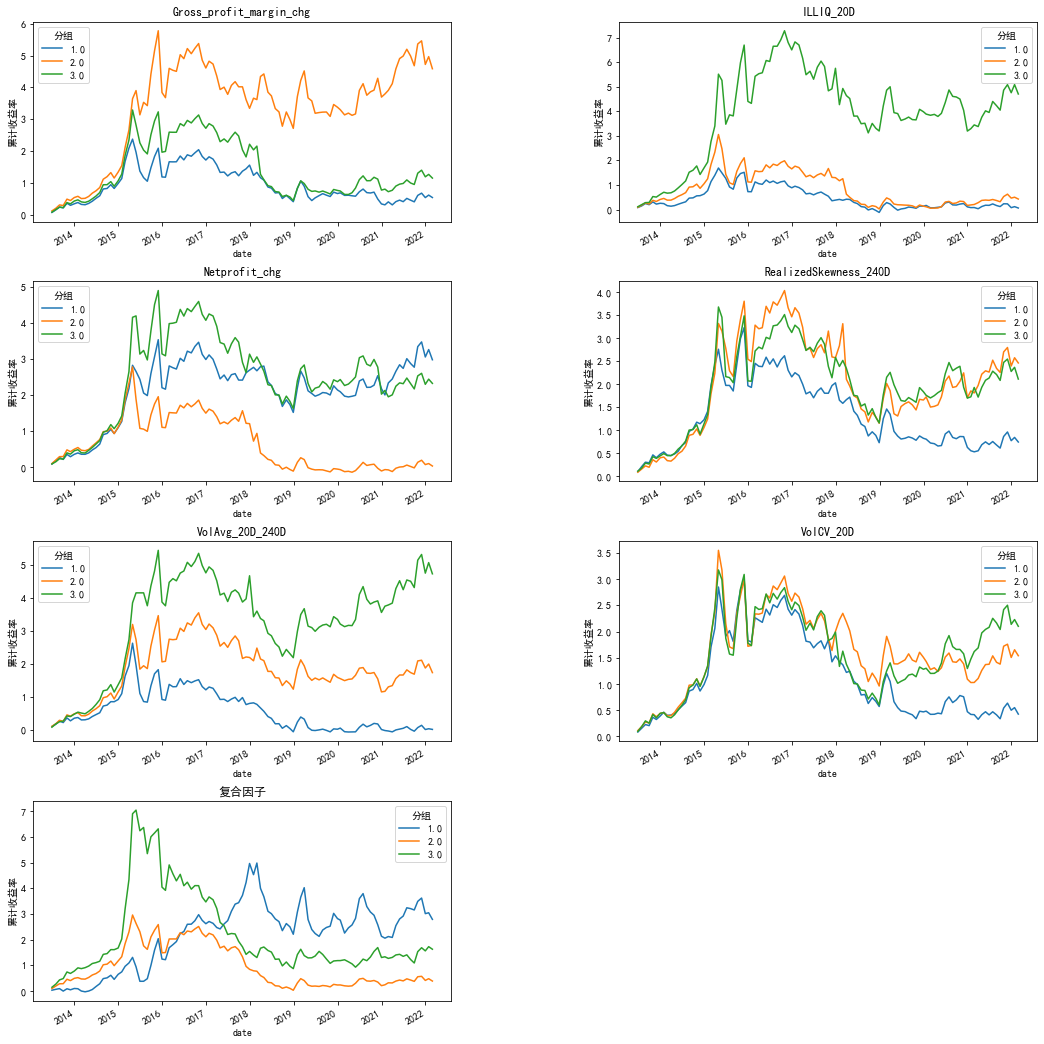

In [12]:
plotting_dichotomy_res(res2['导入期'])

### 成长期

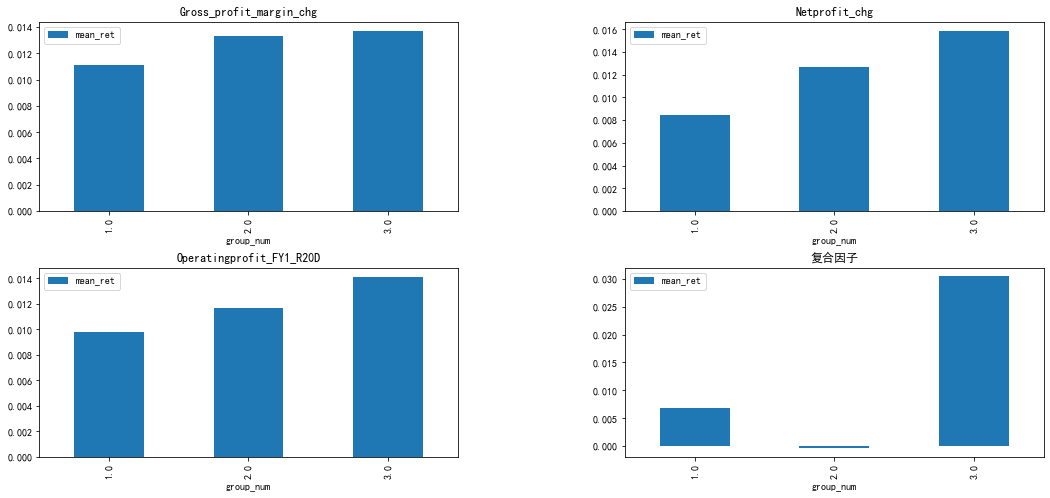

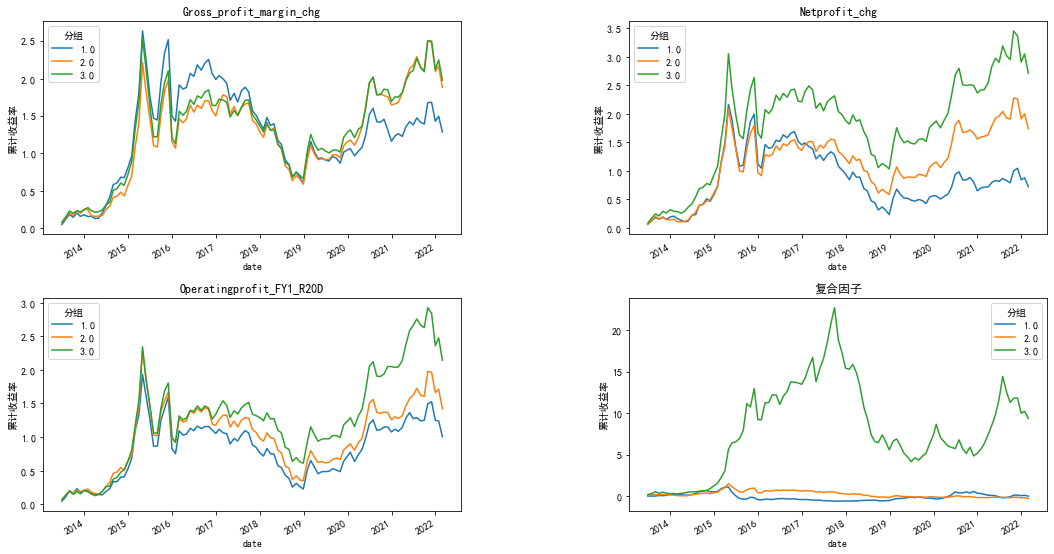

In [13]:
plotting_dichotomy_res(res2['成长期'])

### 成熟期

In [14]:
res2['成熟期'].ic_info_table

IC Mean   IC Std.  Risk-Adjusted IC  \
factor_name              group_num                                         
BP_LR                    1.0       -0.005336  0.160199         -0.033307   
                         2.0        0.016554  0.101050          0.163820   
                         3.0        0.007389  0.197753          0.037364   
EP_Fwd12M                1.0        0.016908  0.158262          0.106838   
                         2.0        0.006731  0.149587          0.045000   
                         3.0       -0.003940  0.184856         -0.021314   
Operatingprofit_FY1_R20D 1.0        0.007271  0.127128          0.057196   
                         2.0        0.003047  0.095534          0.031898   
                         3.0        0.005729  0.117325          0.048831   
Sales2EV                 1.0        0.000338  0.165442          0.002043   
                         2.0        0.009391  0.141982          0.066145   
                         3.0       -0.009429  0.110582         -0.085268   
复合因子                     1.0        0.058538  0.219755          0.266376   
                         2.0        0.028826  0.148330          0.194339   
                         3.0        0.035338  0.213582          0.165454   

                                    t-stat(IC)  p-value(IC)   IC Skew  \
factor_name              group_num                                      
BP_LR                    1.0         -0.341291     0.733573 -0.500672   
                         2.0          1.678660     0.096221  0.066135   
                         3.0          0.382872     0.702596  0.163224   
EP_Fwd12M                1.0          1.094765     0.276149 -0.800079   
                         2.0          0.461112     0.645681  0.734291   
                         3.0         -0.218399     0.827546  0.282333   
Operatingprofit_FY1_R20D 1.0          0.586083     0.559090  0.794193   
                         2.0          0.326862     0.744430  0.034158   
                         3.0          0.500369     0.617873 -0.657657   
Sales2EV                 1.0          0.020936     0.983337 -0.022089   
                         2.0          0.677781     0.499416  0.045445   
                         3.0         -0.873739     0.384274 -0.847663   
复合因子                     1.0          2.729545     0.007449 -0.699608   
                         2.0          1.991384     0.049061 -0.125673   
                         3.0          1.695399     0.092992  0.421409   

                                    IC Kurtosis  mean_ret  
factor_name              group_num                         
BP_LR                    1.0           1.355710  0.010581  
                         2.0           0.260436  0.015653  
                         3.0           0.047869  0.015884  
EP_Fwd12M                1.0           4.907669  0.011323  
                         2.0           3.384246  0.014324  
                         3.0           0.371602  0.014991  
Operatingprofit_FY1_R20D 1.0           5.016534  0.012070  
                         2.0           0.413870  0.012031  
                         3.0           4.076793  0.015510  
Sales2EV                 1.0           0.122479  0.013126  
                         2.0          11.139975  0.013847  
                         3.0           5.697988  0.015127  
复合因子                     1.0           1.521255  0.003073  
                         2.0           4.024259  0.014715  
                         3.0           0.380463  0.024326

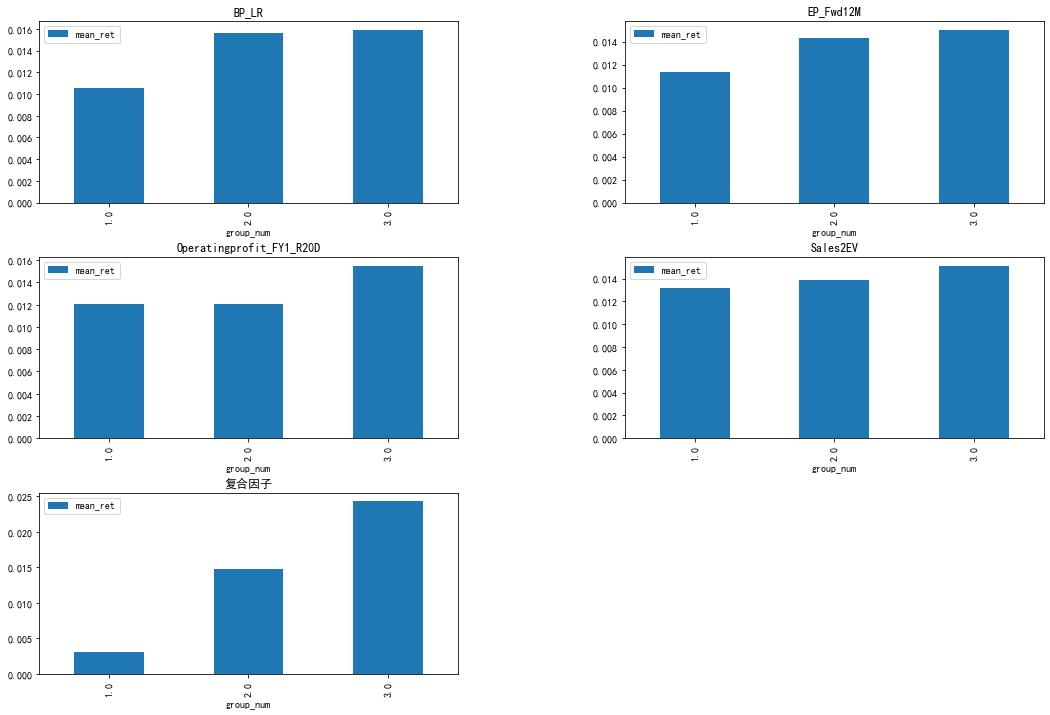

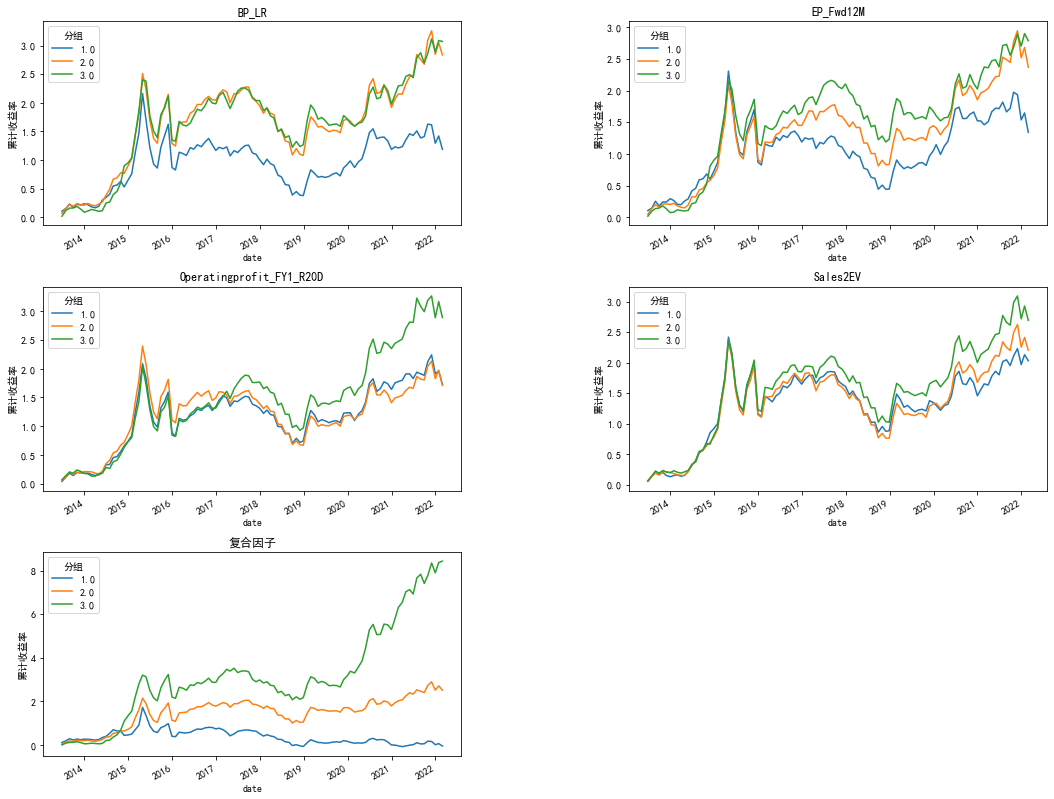

In [15]:
plotting_dichotomy_res(res2['成熟期'])

### 衰退期

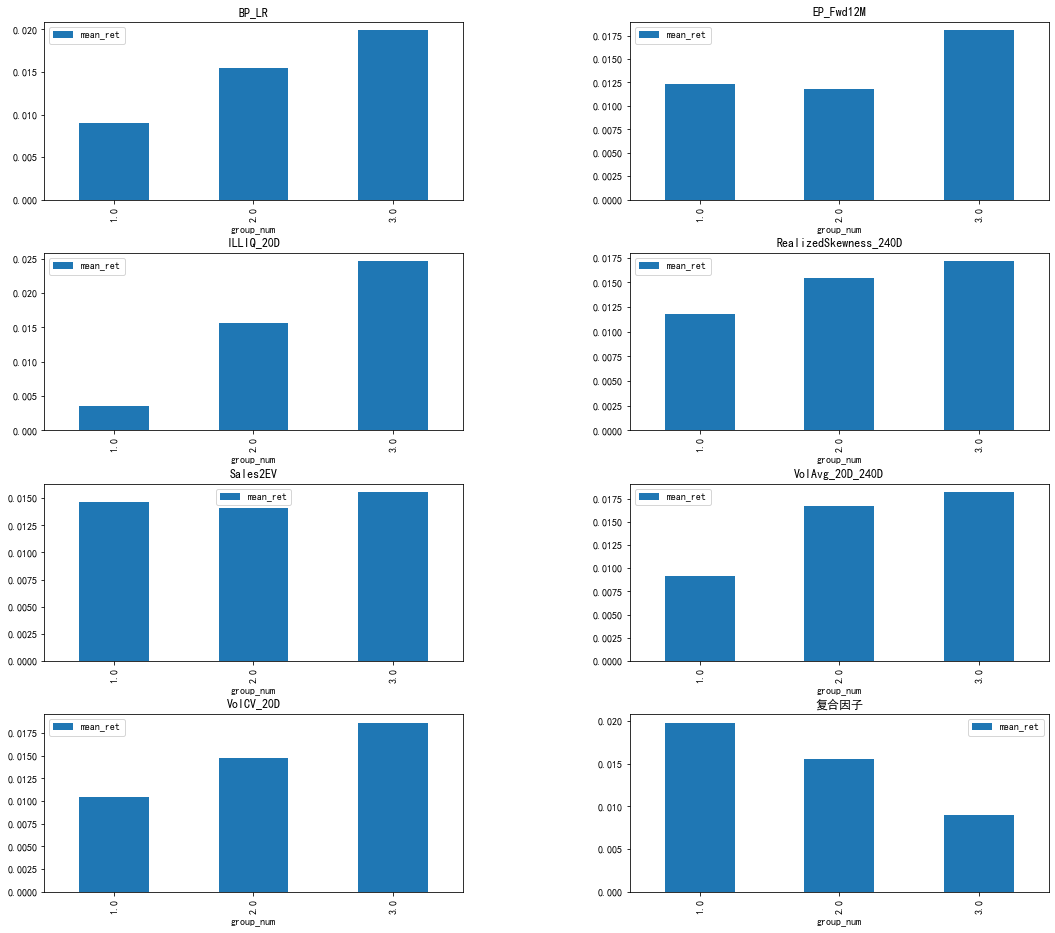

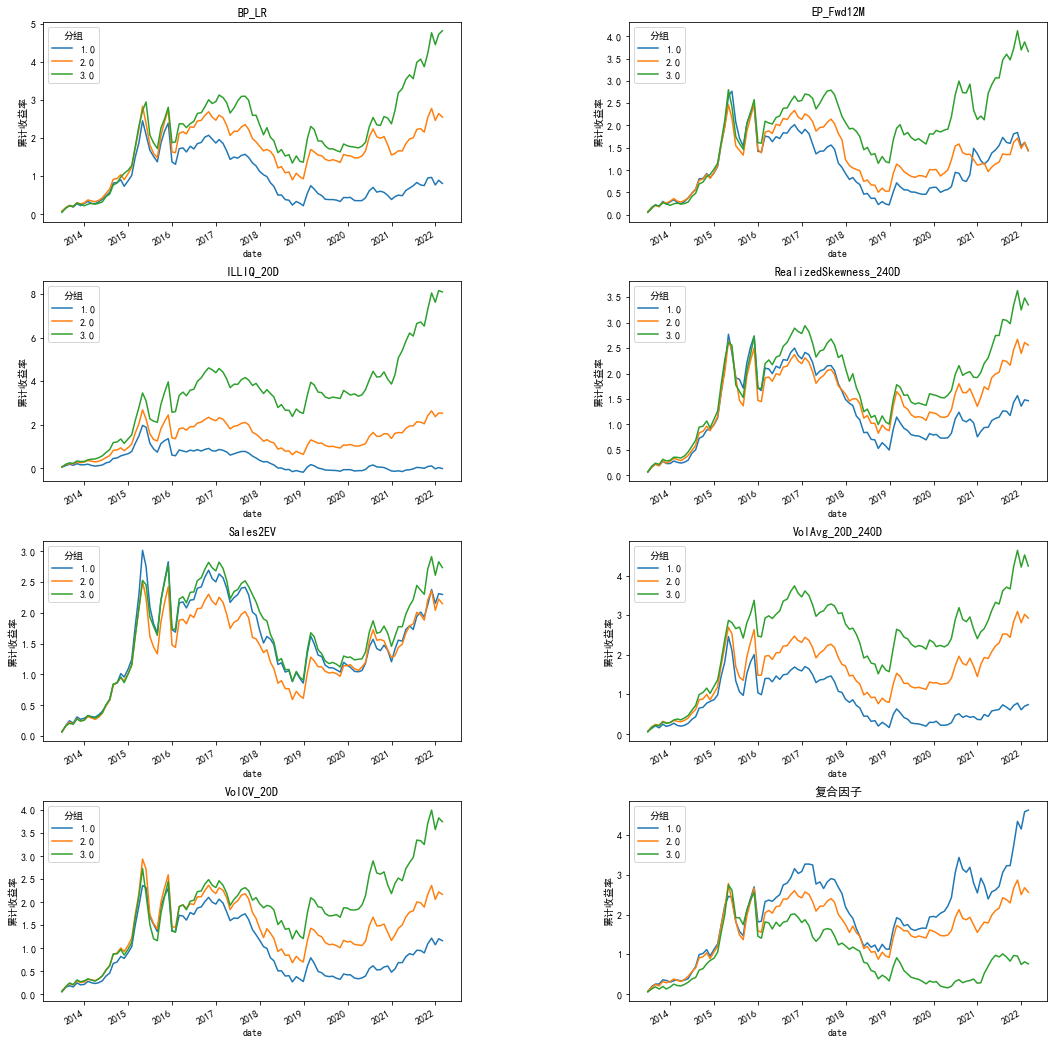

In [16]:
plotting_dichotomy_res(res2['衰退期'])

## 将四个象限简单复合

将四个象限中的复合因子合并起来进行合并

- 获取四个象限中的“复合因子”中的第三组并选择因子值中的最大的30个支进行持有(月度轮动)

In [15]:

com_res = get_com_returns(res2,'复合因子',3,30,True)

com_ret = get_com_frame(com_res).unstack().T
cum_ret = ep.cum_returns(com_ret)

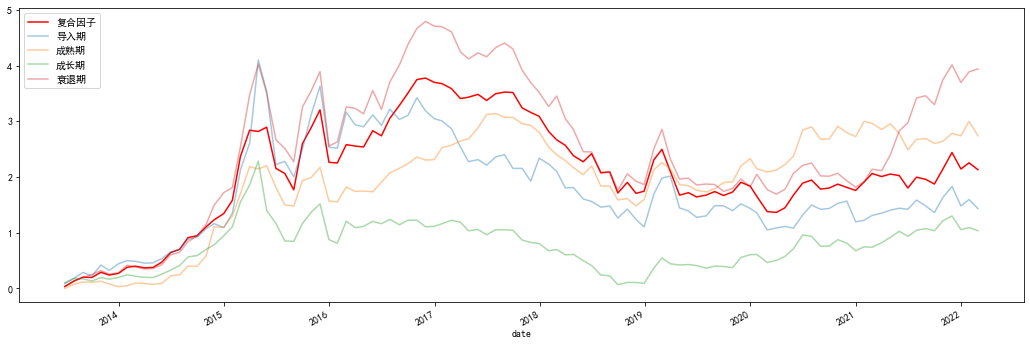

In [16]:
line = cum_ret.plot.line(y=['复合因子'], color='red', figsize=(18, 6))

cum_ret.plot.line(ax=line, y=['导入期', '成熟期', '成长期', '衰退期'], alpha=0.4);

In [17]:
com_ret.columns.names = ['风险指标']

com_ret.apply(perf_stats,period='monthly')

风险指标,导入期,成长期,衰退期,成熟期,复合因子
Annual return,0.106811,0.084461,0.200323,0.162663,0.139287
Cumulative returns,1.430213,1.032920,3.941499,2.738697,2.129968
Annual volatility,0.345909,0.281508,0.307559,0.247755,0.271475
Sharpe ratio,0.460061,0.430369,0.747440,0.728835,0.613916
Calmar ratio,0.178345,0.124781,0.373814,0.405552,0.275435
Stability,0.021313,0.018468,0.189241,0.552801,0.145406
Max drawdown,-0.598905,-0.676871,-0.535889,-0.401090,-0.505698
Omega ratio,1.461357,1.419194,1.793958,1.881369,1.655324
Sortino ratio,0.799910,0.665721,1.330318,1.441772,1.063620
Skew,0.703392,-0.149886,0.292054,1.026514,0.539726


## 筛选强势因子进行复合

获取四个象限中因子最强的两个因子进行复合

In [10]:
# 获取强势因子
strong_factor = {}

for name in QUADRANT2FACTOR.keys():
    
    df = res2[name].ic_info_table.copy()
    
    df = df.drop('复合因子', axis=0)
    
    strong_factor[name] = get_max_factor_name(df, 2)

# 获取强势因子的方向
direction_dic1 = {}

for k, v in strong_factor.items():

    factor_des = {}
    for factor_name in v:

        factor_des[factor_name] = direction_dic[k][factor_name]

    direction_dic1[k] = factor_des

# 用于回测的因子设置
quandrant_dic1 = {}

for k, v in quadrant_dic.items():

    factors_ls = []

    for factor_name in v[1]:

        if factor_name in strong_factor[k]:

            factors_ls.append(factor_name)

    quandrant_dic1[k] = (v[0], factors_ls)


In [11]:
res3 = get_factor_res(quandrant,
                      factors_frame,
                      pricing,
                      quandrant_dic1,
                      group_num=3,
                      direction=direction_dic1,
                      comp_params={'method':'pca',
                                   'window':5,
                                   'is_rank':False})

In [12]:
com_res1 = get_com_returns(res3,'复合因子',3,30,True)

com_ret1 = get_com_frame(com_res1).unstack().T
cum_ret1 = ep.cum_returns(com_ret1)

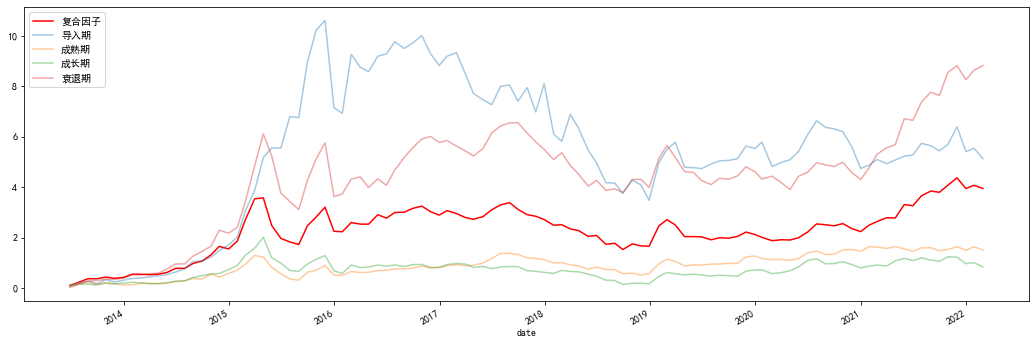

In [13]:
line1 = cum_ret1.plot.line(y=['复合因子'], color='red', figsize=(18, 6))

cum_ret1.plot.line(ax=line1, y=['导入期', '成熟期', '成长期', '衰退期'], alpha=0.4);

In [14]:
com_ret1.columns.names = ['风险指标']

com_ret1.apply(perf_stats,period='monthly')

风险指标,导入期,成长期,衰退期,成熟期,复合因子
Annual return,0.230296,0.072001,0.298479,0.110635,0.200546
Cumulative returns,5.131730,0.837416,8.830063,1.504673,3.949542
Annual volatility,0.361081,0.281226,0.331427,0.247981,0.296163
Sharpe ratio,0.752039,0.389220,0.957641,0.545914,0.764114
Calmar ratio,0.374778,0.115834,0.707107,0.258738,0.447579
Stability,0.274668,0.157874,0.540161,0.738706,0.395509
Max drawdown,-0.614486,-0.621587,-0.422113,-0.427597,-0.448069
Omega ratio,1.838304,1.370297,2.161105,1.559156,1.897522
Sortino ratio,1.361348,0.601796,1.802609,0.924796,1.414287
Skew,0.460534,-0.130552,0.243873,0.314301,0.516397


In [17]:
com_res1['复合因子'].factor_original_frame.to_csv('hold_frame.csv',encoding='gbk')